## JPL Demo Notebook
This notebook demonstrates the functionality of JPL. We show how to load the model and perform detection on a single example image. We also show some example images from minidepth.

### Basic Setup

Import packages, set device and define utility functions

In [56]:
import cv2
import flow_vis
from matplotlib import pyplot as plt
import numpy as np
import torch
from gluefactory.models import get_model

In [57]:
# We want larger figures
plt.rcParams["figure.figsize"] = (7,7)

In [58]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_built():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


In [59]:
def get_flow_vis(df, ang, line_neighborhood=5):
    """Visualize flow of angle field"""
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions.
    Used when loading single Images, not from a glue-factory dataset"""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

def load_image_from_path(path: str, resize=(800,800), plot_image=True):
    img = cv2.resize(cv2.imread(path), resize)
    if plot_image:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
    img_torch = numpy_image_to_torch(img).to(device)
    img_torch = img_torch.unsqueeze(0)
    return img_torch

Import and visualize demo picture

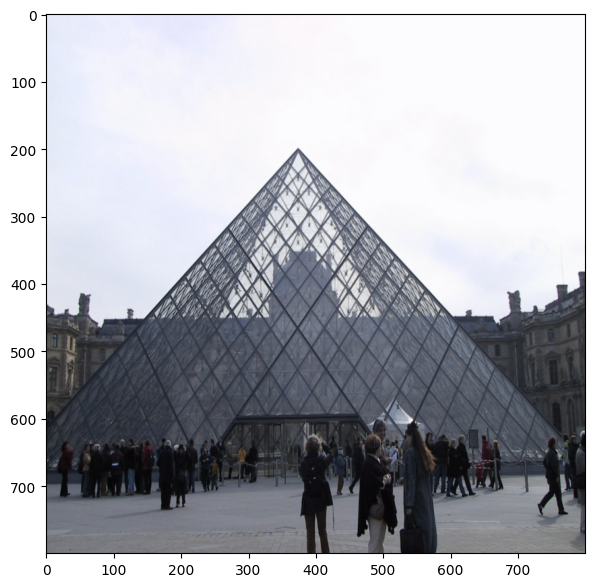

In [60]:
size = (800,800)
image_path = f"demo_louvre.jpg"
torch_image = load_image_from_path(image_path, resize=size, plot_image=True)

### Load the Model

Here we give no configuration. The weights are downloaded automatically and should agree with the default conf. Also, the line_detection is activated by default.

Currently the loaded model is oxparis-800-focal. The line detection is heuristic filtering based on the line-distance field

In [61]:
# The following config is an example that can be used to for ex. activate timing or deactivate line-detection. or having different checkpoint with different architecture (here oxparis_scannet_focal_800 where the number of channels is 64 instead of 32)
jpl_conf = {
    "max_num_keypoints": 1024,  # setting for training, for eval: -1
    "timeit": True,  # model collects timing statistics internally during forward passes
    "line_detection": {
        "do": True
    },
    "line_df_decoder_channels": 64,
    "checkpoint": "https://filedn.com/lt6zb4ORSwapNyVniJf1Pqh/JPL/checkpoint_oxparis_scannet_800_focal.tar"
}

# load the default model
jpldd_model = get_model("joint_point_line_extractor")(jpl_conf).to(device)
jpldd_model.eval()

[03/20/2025 15:08:50 gluefactory.models.lines.pold2_extractor INFO] Brute force sampling for distance field with 1131 samples
[03/20/2025 15:08:50 gluefactory.models.lines.pold2_extractor INFO] Loading weights from /Users/rkre/PycharmProjects/glue-factory/data/line_extraction_coeffs/coeffs_df_800.npy and /Users/rkre/PycharmProjects/glue-factory/data/line_extraction_coeffs/coeffs_df_second_800.npy


JointPointLineDetectorDescriptor(
  (encoder_backbone): AlikedEncoder(
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (pool4): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (gate): SELU(inplace=True)
    (block1): ConvBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResBlock(
      (gate): SELU(inplace=True)
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [62]:
# run fw pass with one image
with torch.no_grad():
    output_jpldd = jpldd_model({"image": torch_image})

print("-- Output Keys --")
for i, key in enumerate(output_jpldd.keys()):
    print(f"{i}: {key}, shape: {output_jpldd[key][0].shape}")

-- Output Keys --
0: keypoint_and_junction_score_map, shape: torch.Size([800, 800])
1: line_distancefield, shape: torch.Size([800, 800])
2: keypoints, shape: torch.Size([1024, 2])
3: keypoint_scores, shape: torch.Size([1024])
4: descriptors, shape: torch.Size([1024, 128])
5: lines, shape: torch.Size([186, 2, 2])
6: line_descriptors, shape: torch.Size([186, 2, 128])
7: valid_lines, shape: torch.Size([186])


### Visualize results

In [63]:
def visualize_jpl_output(image, output_dictionary: dict):
    num_subplots = 3
    has_line_af = "line_anglefield" in list(output_dictionary.keys())
    has_lines = "lines" in list(output_dictionary.keys())
    if has_line_af:
        num_subplots += 1
    if has_lines:
        num_subplots += 1
    fig, ax = plt.subplots(1, num_subplots, figsize=(16, 4))
    ax[0].axis('off')
    ax[0].set_title('KeyPoint & Junction Heatmap')
    ax[0].imshow(output_jpldd["keypoint_and_junction_score_map"][0])

    ax[1].axis('off')
    ax[1].set_title('Distance Field')
    ax[1].imshow(output_jpldd["line_distancefield"][0])

    keypoints = output_dictionary["keypoints"][0]
    ax[2].axis('off')
    ax[2].set_title('Detected keypoints')
    ax[2].imshow(image.cpu().squeeze(0).permute(1,2,0))
    ax[2].scatter(keypoints[:, 0], keypoints[:, 1], marker="o", color="red", s=3)
    if has_line_af:
        ax[3].axis('off')
        ax[3].set_title('Angle Field')
        ax[3].imshow(get_flow_vis(output_jpldd["line_distancefield"][0], output_jpldd["line_anglefield"][0]))
    if has_lines:
        axis_idx = 3 if not has_line_af else 4
        lines = output_dictionary["lines"][0]
        ax[axis_idx].imshow(image.cpu().squeeze(0).permute(1,2,0))
        ax[axis_idx].axis('off')
        ax[axis_idx].set_title('Detected Lines')
        print("Number of detected lines", lines.shape[0])
        for i in range(lines.shape[0]):
            line = lines[i]
            x1,y1 = line[0]
            x2,y2 = line[1]
            ax[axis_idx].plot([x2,x1],[y2,y1],'y-')
    plt.show()

Number of detected lines 186


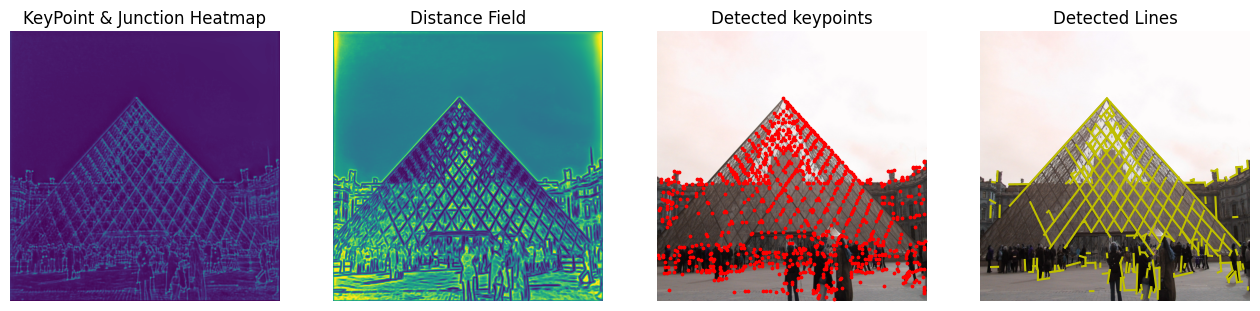

In [64]:
visualize_jpl_output(torch_image, output_jpldd)

## Visualize Results on Minidepth

In [65]:
def visualize_img_with_gt(dset, num=5, offset=0, lim_kpoints=-1):
    idxs = list(range(offset, offset+num, 1))
    _, ax = plt.subplots(len(idxs), 4, figsize=(20, num*4))
    for i in idxs:
        elem = dset[i]

        af = elem["deeplsd_angle_field"]
        df = elem["deeplsd_distance_field"]
        hmap = elem["superpoint_heatmap"]
        orig_pt = elem["gt_keypoints"]

        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Heatmap ({hmap.shape})')
        ax[i, 0].imshow(hmap)

        ax[i, 1].axis('off')
        ax[i, 1].set_title('Distance Field')
        ax[i, 1].imshow(df)

        ax[i, 2].axis('off')
        ax[i, 2].set_title('Angle Field')
        ax[i, 2].imshow(get_flow_vis(df, af))

        ax[i, 3].axis('off')
        ax[i, 3].set_title('Original')
        ax[i, 3].imshow(elem["image"].permute(1,2,0))
        ax[i, 3].scatter(orig_pt[:lim_kpoints, 0], orig_pt[:lim_kpoints, 1], marker="o", color="red", s=3)
    plt.show()

def compute_and_visualize(img_data_with_gt, model, device, visualize=False):
    # compute forward-pass
    img_torch = img_data_with_gt["image"].to(device).unsqueeze(0)
    with torch.no_grad():
        output_model = model({"image": img_torch})

    jpldd_kpjhm = output_model['keypoint_and_junction_score_map'][0].cpu()
    jpldd_df = output_model['line_distancefield'][0].cpu()
    jpldd_kp = output_model['keypoints'][0].cpu()

    df_gt = img_data_with_gt["deeplsd_distance_field"].cpu()
    hmap_gt = img_data_with_gt["superpoint_heatmap"].cpu()
    orig_pt_gt = img_data_with_gt["gt_keypoints"].cpu()
    print(f"Num of gt-keypoints: {orig_pt_gt.shape[0]}")

    num_axis = 3
    # line-anglefield
    has_line_af = "line_anglefield" in list(output_model.keys())
    if has_line_af:
        jpldd_af = output_model['line_anglefield'][0].cpu()
        af_gt = img_data_with_gt["deeplsd_angle_field"].cpu()
        num_axis += 1
    # lines
    has_lines = "lines" in list(output_model.keys())
    if has_lines:
        lines = output_model["lines"][0].cpu()
        num_axis += 1

    if visualize:
        _, ax = plt.subplots(2, num_axis, figsize=(20, 8))
        ax[0, 0].axis('off')
        ax[0, 0].set_title('GT-Heatmap')
        ax[0, 0].imshow(hmap_gt)

        ax[0, 1].axis('off')
        ax[0, 1].set_title('GT - Distance Field')
        ax[0, 1].imshow(df_gt)

        ax[0, 2].axis('off')
        ax[0, 2].set_title('GT-Keypoints')
        ax[0, 2].imshow(img_data_with_gt["image"].permute(1,2,0))
        ax[0, 2].scatter(orig_pt_gt[:, 0], orig_pt_gt[:, 1], marker="o", color="red", s=3)

        if has_line_af:
            ax[0, 3].axis('off')
            ax[0, 3].set_title('GT - Angle Field')
            ax[0, 3].imshow(get_flow_vis(df_gt, af_gt))

        if has_lines:
            axis_idx = 3 if not has_line_af else 4
            ax[0, axis_idx].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
            ax[0, axis_idx].axis('off')
            ax[0, axis_idx].set_title('GT-Lines (CURRENTLY NOT VISUALIZED/LOADED)')


        ax[1, 0].axis('off')
        ax[1, 0].set_title('KP&J Heatmap')
        ax[1, 0].imshow(jpldd_kpjhm)

        ax[1, 1].axis('off')
        ax[1, 1].set_title('Distance Field')
        ax[1, 1].imshow(jpldd_df)

        ax[1, 2].axis('off')
        ax[1, 2].set_title('Detected kp')
        ax[1, 2].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
        ax[1, 2].scatter(jpldd_kp[:, 0], jpldd_kp[:, 1], marker="o", color="red", s=3)

        if has_line_af:
            ax[1, 3].axis('off')
            ax[1, 3].set_title('Angle Field')
            ax[1, 3].imshow(get_flow_vis(jpldd_df, jpldd_af))

        if has_lines:
            axis_idx = 3 if not has_line_af else 4
            ax[1, axis_idx].imshow(img_torch.cpu().squeeze(0).permute(1,2,0))
            ax[1, axis_idx].axis('off')
            ax[1, axis_idx].set_title('Detected Lines')
            print("Number of detected lines", lines.shape[0])
            for i in range(lines.shape[0]):
                line = lines[i]
                x1,y1 = line[0]
                x2,y2 = line[1]
                ax[1, axis_idx].plot([x2,x1],[y2,y1],'y-')

        plt.show()
    return output_model

from gluefactory.datasets import get_dataset

[03/20/2025 15:08:52 gluefactory.datasets.base_dataset INFO] Creating dataset OxfordParisMiniOneViewJPLDD
[03/20/2025 15:08:52 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] DATASET OVERALL(NO-SPLIT) IMAGES: 12000
[03/20/2025 15:08:52 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES: 11500
[03/20/2025 15:08:52 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] KNOWN BATCHSIZE FOR MY SPLIT(train) is 2
[03/20/2025 15:08:52 gluefactory.datasets.oxford_paris_mini_1view_jpldd INFO] NUMBER OF IMAGES WITH GT: 11500
/var/folders/_q/2w2_f57d70gbt80st9bylsdw0000gn/T/ipykernel_16316/1566215788.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)


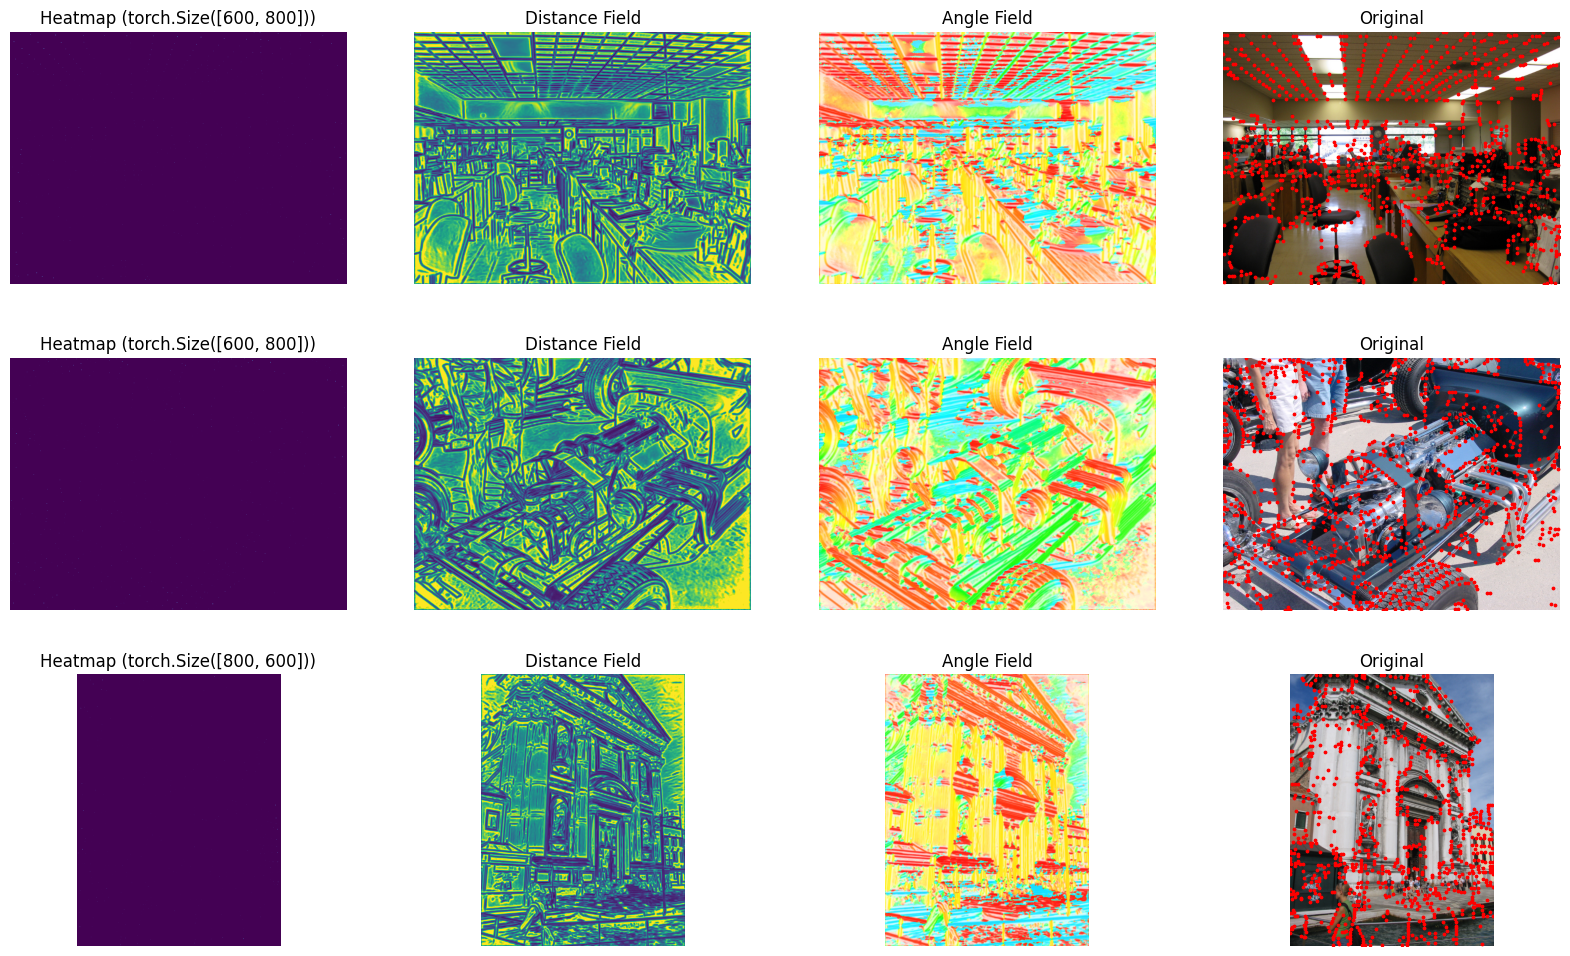

In [66]:
# get dataset (bx default feature-loading is deactivated, so activated it here to show gt)
dset_conf = {
            "reshape": 800,
            "square_pad": False,
            "load_features": {
                "do": True,
                "point_gt": {
                    "load_points": True,
                    "use_score_heatmap": True,
                    "max_num_heatmap_keypoints": -1,
                    "max_num_keypoints": 1500,
                },
            },
        }
#oxparis datset name: oxford_paris_mini_1view_jpldd
loaded_ds = get_dataset("oxford_paris_mini_1view_jpldd")(dset_conf)
ds = loaded_ds.get_dataset(split="train")

# load some test elements
visualize_img_with_gt(ds, num=3)

Num of gt-keypoints: 600
Number of detected lines 130


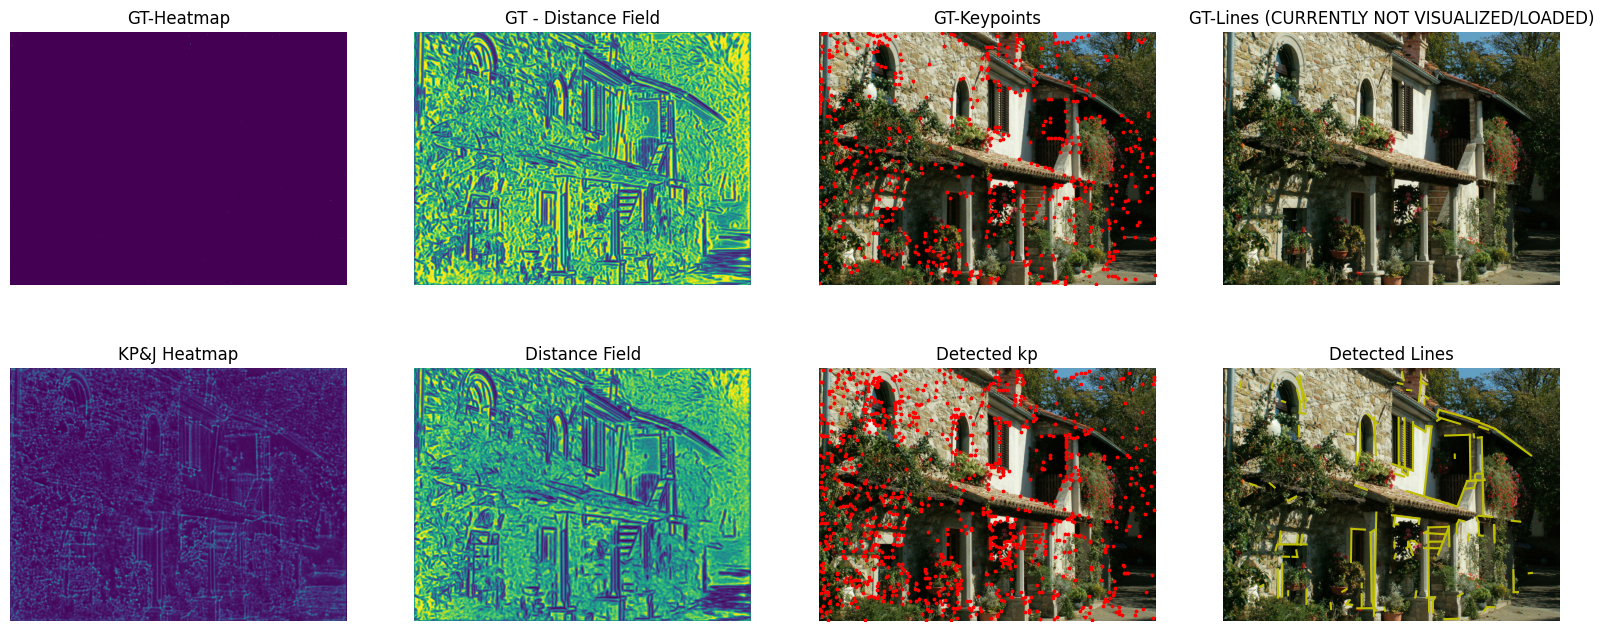

In [67]:
# Compute prediction with images from the dataset and visualize with ground truth
output = compute_and_visualize(ds[42], jpldd_model, device, visualize=True)

## Check Timings

To get a better insight into how long each part of the pipeline takes during forward pass, we implemented the option to collect inner timings. In order to be able to get inner timings, you need to set `timeit: True` in the configuration, as it is deactivated by default.

Why?: collecting inner timings involves synchronizing CUDA operations before each measurement. This negatively affects the overall throughput slightly.

If you chose the alternative jpl_conf in the 1st cell, timeit is activated and you can continue. Otherwise, the following commands will not work.

In [68]:
# get inner timings as dictionary. Use reset option to delete collected data up to date.
timings = jpldd_model.get_current_timings(reset=False)
for net_part, time in timings.items():
    print(f"{net_part}: {time}")

total-makespan: 1.0935602188110352
encoder: 0.11602199077606201
keypoint-and-junction-heatmap: 0.02844095230102539
line-df: 0.3356480598449707
descriptor-branch: 0.07281982898712158
keypoint-detection: 0.2991466522216797
line-detection: 0.16477441787719727
